In [1]:
%pip install openpyxl catboost scikit-learn -q
# %pip install numpy==1.24.1
%pip install joblib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score

from catboost import CatBoostClassifier, CatBoostRegressor, Pool
import joblib
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
raw_data = pd.read_excel('https://github.com/Jodode/student_scoring/raw/main/scoring_data.xlsx')

In [4]:
print(f'Количество уникальных хешей и ЛД: {len(raw_data["hash"].unique())} и {len(raw_data["Номер ЛД"].unique())}')

Количество уникальных хешей и ЛД: 9085 и 9098


In [5]:
def cast_types(df):

    df = df.drop(columns=['hash', ])
    
    grades_dict = {'Отлично': 5, np.nan: 2, 'зачтено': 3, 'Хорошо': 4, 'не зачтено': 2,
     'Неявка': 2, 'Неудовлетворительно': 2, 'Удовлетворительно': 3,
     'Не допущен': 2, 'Неявка по ув.причине': 2}

    # df['Полугодие'] = df['Полугодие'].map({'I полугодие' : 1, 'II полугодие' : 2})
    
    df['Оценка (без пересдач)'] = df['Оценка (без пересдач)'].map(grades_dict)
    df['Оценка (успеваемость)'] = df['Оценка (успеваемость)'].map(grades_dict)

    major_to_uni = {
        'Бизнес-информатика': 'ИКН',
        'Информатика и вычислительная техника': 'ИКН',
        'Информатика и вычислительная техника (ИВТ, ИСТ, ПИ)': 'ИКН',
        'Информационные системы и технологии': 'ИКН',
        'Прикладная информатика': 'ИКН',
        'Прикладная математика': 'ИКН',
        'Горное дело': 'Горный',
        'Геотехнологии (Горное дело, Физические процессы горного или нефтегазового производства)': 'Горный',
        'Техносферная безопасность': 'Горный',
        'Электроэнергетика и электротехника': 'Горный',
        'Физические процессы горного или нефтегазового производства': 'Горный',
        'Технологические машины и оборудование': 'ИТ',
        'Наноматериалы': 'ИНМ',
        'Электроника и наноэлектроника': 'ИНМ',
        'Материаловедение и технологии материалов': 'ИНМ',
        'Физика': 'ИНМ',
        'Экономика и управление (Экономика,Менеджмент)': 'ИЭУ',
        'Экономика': 'ИЭУ',
        'Менеджмент': 'ИЭУ',
        'Металлургия': 'ИТ',
        'Лингвистика': 'ИБО',
        'Нанотехнологии и микросистемная техника': 'ИНМ', 
        'Нанотехнологии и наноматериалы (Нанотехнологии и микросистемная техника, Наноматериалы)': 'ИНМ',
        'Стандартизация и метрология': 'ИТ',
        'Управление качеством': 'ИТ',
        'Управление в технических системах': 'ИТ',
        'Наземные транспортно-технологические средства': 'ИТ'
    }
    
    df['Институт'] = df['Специальность/направление'].apply(lambda x: major_to_uni[x])

    df = df[~df['Учебный год'].isin(['2024 - 2025', '2025 - 2026', '2026 - 2027', '2027 - 2028'])]

    return df

def feature_eng(df):
    df['Год начала обучения'] = df['Учебная группа'].str.extract(r'(\d{2})').astype(int) + 2000
    df['Год начала семестра'] = df['Учебный год'].str.split(' - ').str[0].astype(int)

    def calculate_semester(row):
            year_difference = row['Год начала семестра'] - row['Год начала обучения']
            return year_difference * 2 + 2 if row['Полугодие'] == 'II полугодие' else year_difference * 2 + 1
        
    df['Номер семестра'] = df.apply(calculate_semester, axis=1)

    return df
    

In [6]:
data = raw_data.pipe(cast_types).pipe(feature_eng)

In [7]:
del raw_data

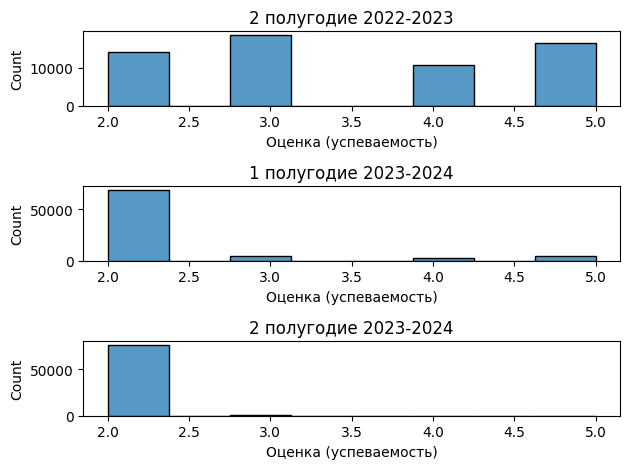

In [8]:
fig, axs = plt.subplots(3, 1)
sns.histplot(data=data[((data['Полугодие'] == 'II полугодие') & (data['Учебный год'] == '2022 - 2023'))], x='Оценка (успеваемость)', ax=axs[0], bins=8).set_title('2 полугодие 2022-2023')
sns.histplot(data=data[((data['Полугодие'] == 'I полугодие') & (data['Учебный год'] == '2023 - 2024'))], x='Оценка (успеваемость)', ax=axs[1], bins=8).set_title('1 полугодие 2023-2024')
sns.histplot(data=data[((data['Полугодие'] == 'II полугодие') & (data['Учебный год'] == '2023 - 2024'))], x='Оценка (успеваемость)', ax=axs[2], bins=8).set_title('2 полугодие 2023-2024')
fig.tight_layout();

In [9]:
data = data[~(data['Учебный год'] == '2023 - 2024')]

In [10]:
test = data[((data['Полугодие'] == 'II полугодие') & (data['Учебный год'] == '2022 - 2023'))]
train = data[~((data['Полугодие'] == 'II полугодие') & (data['Учебный год'] == '2022 - 2023'))]

In [11]:
print(f'Соотношение валидационных и тренировочных данных - {round(test.shape[0] / train.shape[0], 2)} : {1 - round(test.shape[0] / train.shape[0], 2)}')

Соотношение валидационных и тренировочных данных - 0.38 : 0.62


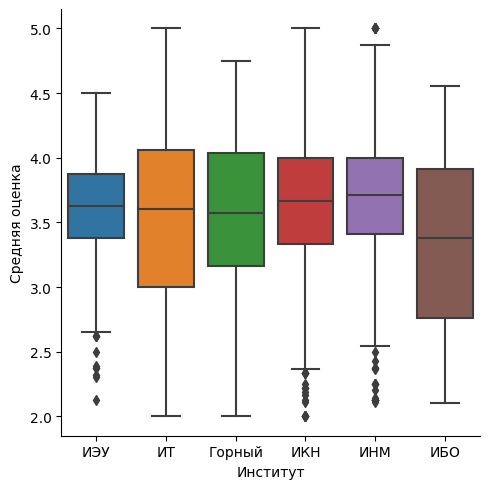

In [12]:
grouped_by_uni = train.groupby(by=['Номер ЛД', ])
mean_by_id = grouped_by_uni.apply(lambda x: x['Оценка (успеваемость)'].mean())
for_visual = pd.DataFrame({'Номер ЛД': np.array(mean_by_id.index), 'Средняя оценка': mean_by_id.values, 'Институт': grouped_by_uni.apply(lambda x: x['Институт'].unique()[0]).values})
sns.catplot(data=for_visual, x='Институт', y='Средняя оценка', kind='box')

In [13]:
mean_by_uni = for_visual.groupby('Институт')['Средняя оценка'].mean()

In [14]:
grade_counts = train.groupby(['Номер ЛД', 'Оценка (успеваемость)']).size().unstack(fill_value=0)
total_grades = grade_counts.sum(axis=1)
grade_shares = grade_counts.divide(total_grades, axis=0)

In [15]:
train['Институт_encoded'] = train['Институт'].apply(lambda x: mean_by_uni[x])
train = train.join(grade_shares, on='Номер ЛД', rsuffix='_доля')

test['Институт_encoded'] = test['Институт'].apply(lambda x: mean_by_uni[x])
test = test.join(grade_shares, on='Номер ЛД', rsuffix='_доля')

In [16]:
# unique_ids = test['Номер ЛД'].unique()

# eval_ids, test_ids = train_test_split(unique_ids, test_size=0.5, random_state=42)

In [17]:
# X_train

In [18]:
X_train = train.drop(columns=['Оценка (без пересдач)', 'Оценка (успеваемость)', 'Институт'])

X_test = test.drop(columns=['Оценка (без пересдач)', 'Оценка (успеваемость)', 'Институт'])

y_train_no_retakes = train['Оценка (без пересдач)']
y_train_performance = train['Оценка (успеваемость)']
y_test_no_retakes = test['Оценка (без пересдач)']
y_test_performance = test['Оценка (успеваемость)']

In [19]:
cat_features = X_train.columns.get_indexer(X_train.select_dtypes('object').columns)

train_pool = Pool(data=X_train, label=y_train_performance, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test_performance, cat_features=cat_features)

In [ ]:
# categorical_features = ['Уровень подготовки', 'Учебная группа', 'Специальность/направление', 'Учебный год', 'Институт', 'Дисциплина']
# one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', one_hot_encoder, categorical_features)
#     ])

# model_performance = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', MultinomialNB(alpha=1))
# ])

# accuracy_scorer = make_scorer(accuracy_score)

In [20]:
cbr = CatBoostRegressor(learning_rate=0.1, depth=7, iterations=2000, random_state=42, loss_function='RMSE', task_type="GPU")
cbr.fit(train_pool, verbose=False)


In [21]:
cbf = CatBoostClassifier(learning_rate=0.1, depth=7, iterations=1000, random_state=42, loss_function='MultiClass', task_type="GPU")
cbf.fit(train_pool, verbose=False)

In [ ]:
# X_train.columns = X_train.columns.astype(str)
# X_test.columns = X_test.columns.astype(str)

In [20]:
# model_nb = MultinomialNB()

# train_for_nb = X_train[['Институт_encoded', '5', '4', '3', '2', 'Номер семестра', 'Год начала семестра']]
# test_for_nb = X_test[['Институт_encoded', '5', '4', '3', '2', 'Номер семестра', 'Год начала семестра']]
# .fit(train_for_nb, y_train_performance)


# categorical_features = ['Уровень подготовки', 'Учебная группа', 'Специальность/направление', 'Учебный год', 'Полугодие', 'Дисциплина']
# one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', one_hot_encoder, categorical_features)
#     ])

# model_nb = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', MultinomialNB())
# ])

# model_nb.fit(X_train, y_train_performance)

In [21]:
# pd.DataFrame({'feature': cbr.feature_names_, 'weight': cbr.get_feature_importance()}).sort_values('weight')

In [ ]:
# model_performance.fit(X_train, y_train_performance)

In [22]:
# pred_performance = model_performance.predict(X_test)
pred_performance_c = cbf.predict(X_test)
# pred_performance = model_nb.predict(X_test)
pred_performance_r = cbr.predict(X_test)

In [23]:
print(f'CBR report, RMSE: {np.sqrt(mean_squared_error(y_test_performance, pred_performance_r))}')
print(classification_report(y_test_performance, pred_performance_r.round()))
print('-'*100)
# print(f'NB report, RMSE: {np.sqrt(mean_squared_error(y_test_performance, pred_performance))}')
# print(classification_report(y_test_performance, pred_performance))
# print('-'*100)
print(f'CBC report, RMSE: {np.sqrt(mean_squared_error(y_test_performance, pred_performance_c))}')
print(classification_report(y_test_performance, pred_performance_c))



CBR report, RMSE: 0.8875115048046899
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.74      0.31      0.44     14225
         3.0       0.47      0.61      0.53     18780
         4.0       0.27      0.56      0.37     10803
         5.0       0.72      0.35      0.47     16564
         6.0       0.00      0.00      0.00         0

    accuracy                           0.46     60372
   macro avg       0.37      0.30      0.30     60372
weighted avg       0.57      0.46      0.46     60372

----------------------------------------------------------------------------------------------------
CBC report, RMSE: 1.0746810577420673
              precision    recall  f1-score   support

           2       0.64      0.63      0.63     14225
           3       0.57      0.61      0.59     18780
           4       0.35      0.24      0.28     10803
           5       0.57      0.64      0.60     16564

    accura

In [ ]:
# preds = (pred_performance_c + pred_performance_r)
# print('-'*100)
# print(classification_report(y_test_performance, preds.round()))

----------------------------------------------------------------------------------------------------


In [30]:
pred_performance_c = np.array(list(map(lambda x: x[0], pred_performance_c)))

In [34]:
pred_performance_r

array([4.0007121 , 3.37676675, 4.0007121 , ..., 3.0572076 , 3.17777983,
       3.88569543])

In [38]:
preds = 0.5 * pred_performance_c + 0.5 * pred_performance_r
print('-'*100)
print(f'CBC + CBR report, RMSE: {np.sqrt(mean_squared_error(y_test_performance, preds))}')
print(classification_report(y_test_performance, preds.round()))

----------------------------------------------------------------------------------------------------
CBC + CBR report, RMSE: 0.9315141974029173
              precision    recall  f1-score   support

           2       0.68      0.52      0.59     14225
           3       0.52      0.64      0.57     18780
           4       0.30      0.32      0.31     10803
           5       0.63      0.57      0.60     16564

    accuracy                           0.54     60372
   macro avg       0.53      0.51      0.52     60372
weighted avg       0.55      0.54      0.54     60372



0.886618796746411

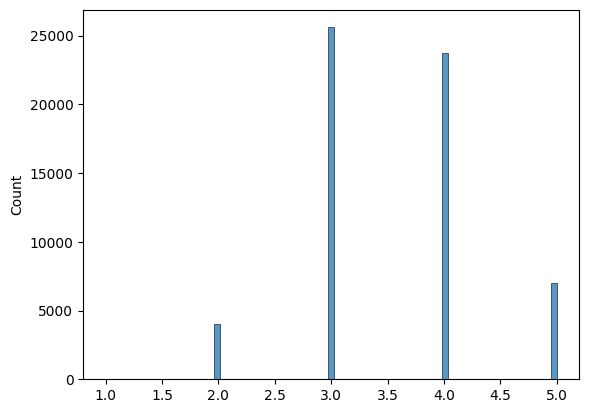

In [200]:
sns.histplot(pred_performance_r.round());
np.sqrt(mean_squared_error(y_test, pred_performance_r.round()))

<Axes: xlabel='Оценка (успеваемость)', ylabel='Count'>

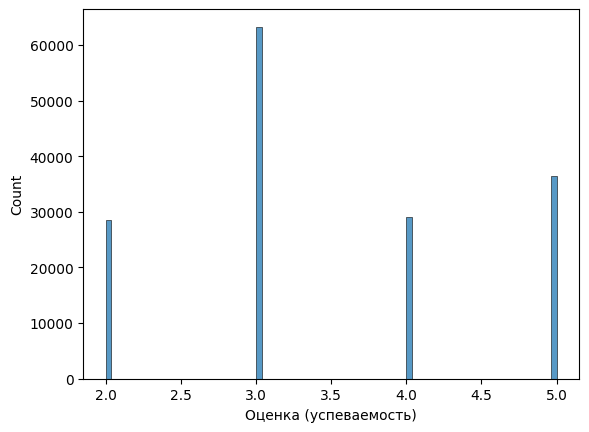

In [64]:
sns.histplot(data=train, x='Оценка (успеваемость)')

0.8916487170249943

In [115]:
y_test_performance

42        4
43        2
44        4
45        5
46        4
         ..
375967    5
375968    4
375969    3
375970    3
375971    4
Name: Оценка (успеваемость), Length: 60372, dtype: int64

In [52]:
X_test[X_test['Номер ЛД'] == 2010218].inde

Index([42, 43, 44, 45, 46, 47, 48, 49, 50], dtype='int64')

In [53]:
train.sample()

,Номер ЛД,Уровень подготовки,Учебная группа,Специальность/направление,Учебный год,Полугодие,Дисциплина,Оценка (без пересдач),Оценка (успеваемость),Год начала обучения,Год начала семестра,Институт,Номер семестра,Институт_encoded
183984,2003116,Академический бакалавр,БПИ-20-8,Прикладная информатика,2020 - 2021,1,Инженерная компьютерная графика,3,3,2020,2020,ИКН,1,3.639175


In [102]:
joblib.dump(cbf, 'catboost_model.pkl')

['catboost_model.pkl']

In [107]:
kek = data.drop(columns=['Институт'])

In [108]:
kek.to_csv('final_data.csv')

In [124]:
kek

,Номер ЛД,Уровень подготовки,Учебная группа,Специальность/направление,Учебный год,Полугодие,Дисциплина,Оценка (без пересдач),Оценка (успеваемость),Год начала обучения,Год начала семестра,Номер семестра
0,2010218,Академический бакалавр,БИВТ-20-4,Информатика и вычислительная техника,2020 - 2021,I полугодие,Инженерная компьютерная графика,4,4,2020,2020,1
1,2010218,Академический бакалавр,БИВТ-20-4,Информатика и вычислительная техника,2020 - 2021,I полугодие,Иностранный язык,3,3,2020,2020,1
2,2010218,Академический бакалавр,БИВТ-20-4,Информатика и вычислительная техника,2020 - 2021,I полугодие,История,3,3,2020,2020,1
3,2010218,Академический бакалавр,БИВТ-20-4,Информатика и вычислительная техника,2020 - 2021,I полугодие,Математика,4,4,2020,2020,1
4,2010218,Академический бакалавр,БИВТ-20-4,Информатика и вычислительная техника,2020 - 2021,I полугодие,Программирование и алгоритмизация,4,4,2020,2020,1
...,...,...,...,...,...,...,...,...,...,...,...,...
375967,2102637,Академический бакалавр,БМТМ-21-1,Материаловедение и технологии материалов,2022 - 2023,II полугодие,Учебная практика по получению первичных профес...,5,5,2021,2022,3
375968,2102637,Академический бакалавр,БМТМ-21-1,Материаловедение и технологии материалов,2022 - 2023,II полугодие,Физика,4,4,2021,2022,3
375969,2102637,Академический бакалавр,БМТМ-21-1,Материаловедение и технологии материалов,2022 - 2023,II полугодие,Физическая культура и спорт,2,3,2021,2022,3
375970,2102637,Академический бакалавр,БМТМ-21-1,Материаловедение и технологии материалов,2022 - 2023,II полугодие,Физическая химия,2,3,2021,2022,3


In [129]:
grade_counts = kek.groupby(['Номер ЛД', 'Оценка (успеваемость)']).size().unstack(fill_value=0)
total_grades = grade_counts.sum(axis=1)
grade_shares = grade_counts.divide(total_grades, axis=0)

In [130]:
grade_shares

Оценка (успеваемость),2,3,4,5
Номер ЛД,,,,
70272,0.327273,0.436364,0.218182,0.018182
100255,0.200000,0.628571,0.142857,0.028571
122905,0.093750,0.812500,0.062500,0.031250
125428,0.000000,0.645570,0.303797,0.050633
125738,0.000000,0.526316,0.157895,0.315789
...,...,...,...,...
2316621,0.692308,0.076923,0.153846,0.076923
2316628,0.071429,0.500000,0.285714,0.142857
2316635,0.526316,0.105263,0.368421,0.000000
